In [1]:
import sys
main_dir = '../'
sys.path.append(main_dir)

import numpy as np
from functools import lru_cache
import scipy.ndimage as sn
from scipy.optimize import minimize, minimize_scalar
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
import scipy.ndimage as sn

import tqdm
import time

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.offsetbox import AnchoredText

import opennu as on

plt.style.use(main_dir+'sty.mplstyle')
cols = ['#0C5DA5', '#00B945', '#FF9500', '#FF2C00', '#845B97', '#474747', '#9e9e9e']

#### SPN limited, ideal, constraint for $^{129}$Xe

In [17]:
de, c2, c2l = on.find_delta(10, 0.05, p_init=1, T2=10, Nshots=10, seed=42, d_init=1e8, d_fin=1e16, ndelta=100,
                 chi2_crit=3.84, squid_noise_ratio=0.0)
ff = 10*100**(3/2)
print("delta: %.2e\n"%(de/ff))# Including T2=1000 s, Nshots=1000

delta: 3.59e+07



#### SPN limited, ideal, constraint for $^{1}$H

In [23]:
de, c2, c2l = on.find_delta(10, 0.05, p_init=1, T2=10, Nshots=10, seed=42, d_init=1e6, d_fin=1e16, ndelta=100,
                 chi2_crit=2.71, squid_noise_ratio=0.0, B=0.3, A=1, Z=1, gy=42.58e6, verb=True)
ff = 10*100**(3/2)
print("delta: %.2e\n"%(de/ff))# Including T2=1000 s, Nshots=1000

At B=0.30, I get w=5.281e-08
g+/g- = 0.9687930
Passed w=5.281e-08, optimal w=1.314e-07,  used w=1.314e-07
g+/g- = 0.9246011
delta: 1.20e+10



#### CASPEr future setup: $R=1$ cm, ${\cal F}_{\rm SQUID}=50$, $p=50$\%

In [20]:
de, c2, c2l = on.find_delta(1, 0.05, p_init=0.5, T2=10, Nshots=10, seed=42, d_init=1e8, d_fin=1e16, ndelta=100,
                 chi2_crit=2.71, squid_noise_ratio=50.0)
ff = 10*100**(3/2)
print("delta: %.2e\n"%(de/ff))# Including T2=1000 s, Nshots=1000

delta: 1.67e+10



## $p$ dependence

In [40]:
pl = np.geomspace(0.001, 1, 20)
dell_p = []
dell_p2 = []
for p in tqdm.tqdm(pl):
    de, _, _  = on.find_delta(10, 0.16, p_init=p, T2=1, Nshots=100, seed=42, d_init=1e7, d_fin=1e19, ndelta=50)
    de2, _, _ = on.find_delta(10, 0.16, p_init=p, T2=1, Nshots=100, seed=23, d_init=1e7, d_fin=1e19, ndelta=50)
    dell_p.append(de)
    dell_p2.append(de2)

dell_p = np.array(dell_p)
dell_p2 = np.array(dell_p2)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:44<00:00,  2.22s/it]


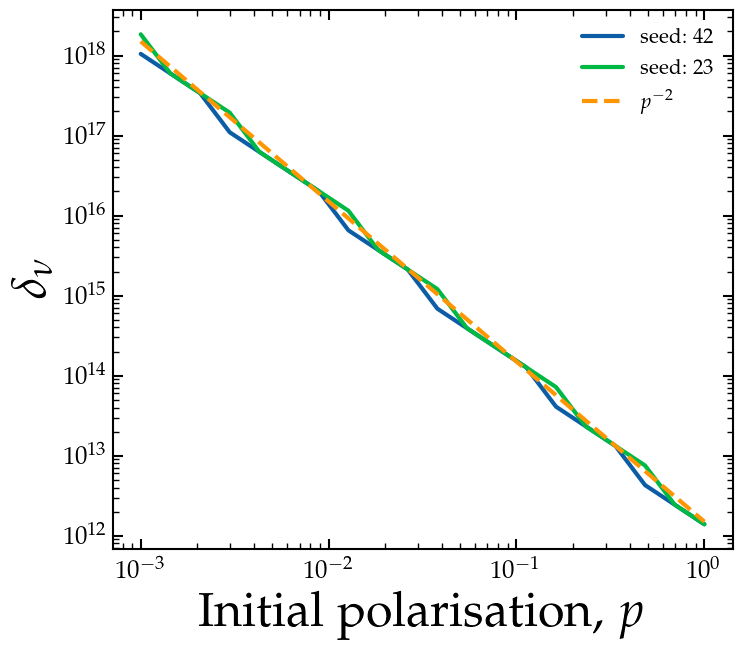

In [41]:
plt.loglog(pl, dell_p, label='seed: 42')
plt.loglog(pl, dell_p2, label='seed: 23')

plt.loglog(pl, 1.5e12*pl**(-2), ls='--', label=r'$p^{-2}$')

plt.xlabel(r'Initial polarisation, $p$')
plt.ylabel(r'$\delta_{\nu}$')
plt.legend()
plt.show()

## $R$ dependence

In [95]:
rl = np.geomspace(0.01, 10, 100)
dell_r = []
dell_r2 = []
for r in tqdm.tqdm(rl):
    de, _, _  = on.find_delta(r, 0.16, p_init=1, T2=1, Nshots=10, seed=42, d_init=1e11, d_fin=1e25, ndelta=200, B=0.1, opt=True)
    de2, _, _ = on.find_delta(r, 0.16, p_init=1, T2=1, Nshots=10, seed=23, d_init=1e11, d_fin=1e25, ndelta=200, B=0.1, opt=False)
    dell_r.append(de)
    dell_r2.append(de2)

dell_r = np.array(dell_r)
dell_r2 = np.array(dell_r2)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:49<00:00,  1.70s/it]


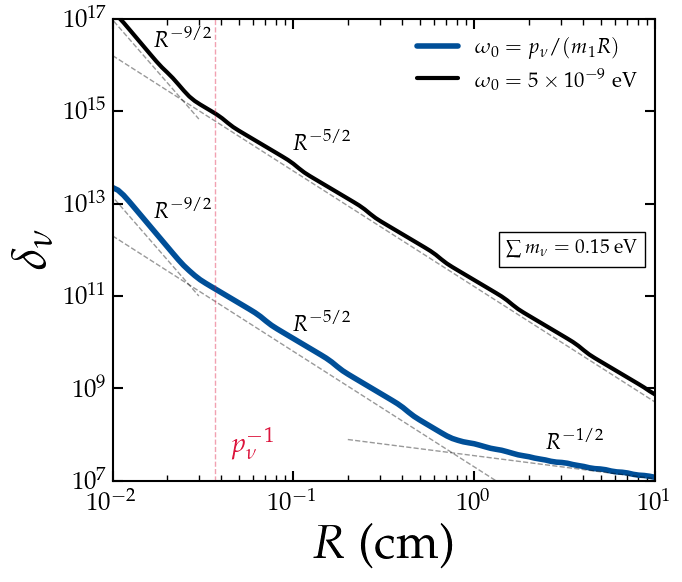

In [129]:
ss = 1

norm = 1000**(3/2)*10

r1 = np.geomspace(0.001, 0.03, 30)
r2 = np.geomspace(0.05, 10, 30)
r3 = np.geomspace(0.1, 10, 30)
r4 = np.geomspace(0.2, 10, 30)

fig, ax = plt.subplots(figsize=(7,6))

plt.loglog(rl, sn.gaussian_filter(dell_r, sigma=ss)/norm, label=r'$\omega_0=p_{\nu}/(m_1 R)$', c='#004f98', lw=4)
plt.loglog(rl, sn.gaussian_filter(dell_r2, sigma=ss)/norm, label=r'$\omega_0=5\times 10^{-9}$ eV', c='k',)

alp = 0.4
plt.loglog(r1, 9.5e7*r1**(-9/2),  ls='--', c='k', lw=1, alpha=alp)
plt.loglog(rl, 1.6e11*rl**(-5/2), ls='--', c='k', lw=1, alpha=alp)
plt.loglog(r1, 1.4e4*r1**(-9/2),  ls='--', c='k', lw=1, alpha=alp)
plt.loglog(rl, 2e7*rl**(-5/2), ls='--', c='k', lw=1, alpha=alp)
plt.loglog(r4, 3.5e7*r4**(-1/2),  ls='--', c='k', lw=1, alpha=alp)

plt.axvline(1/27, alpha=0.4, lw=1, c='crimson', ls='--')
plt.text(0.045, 4e7, r'$p^{-1}_\nu$', c='crimson')

ttfs = 16

plt.text(0.017, 2.5e16, r'$R^{-9/2}$', fontsize=ttfs)
plt.text(0.017, 5e12, r'$R^{-9/2}$', fontsize=ttfs)
plt.text(0.1,  1.5e14, r'$R^{-5/2}$', fontsize=ttfs)
plt.text(0.1,  1.8e10, r'$R^{-5/2}$', fontsize=ttfs)
plt.text(2.5,  5e7, r'$R^{-1/2}$', fontsize=ttfs)

plt.xlim(1e-2, 10)
plt.ylim(1e7, 1e17)

text_box = AnchoredText(
    #r"$m_1=0.05$ eV", 
    r"$\sum m_\nu=0.15$ eV", 
    loc='center right',            
    frameon=True,                
    prop=dict(size=14)
)
ax.add_artist(text_box)

plt.xlabel(r'$R$ (cm)')
plt.ylabel(r'$\delta_{\nu}$')
plt.legend()
plt.show()
fig.savefig(main_dir+'plots/deltaR_scaling.pdf', bbox_inches='tight')

In [27]:
ls

chi2_jz.ipynb      Solutions.ipynb    SteadyState.ipynb


In [28]:
#np.savetxt(main_dir+'/data/R_dep_opt.txt', np.column_stack([rl, sn.gaussian_filter(dell_r, sigma=1)]))
#np.savetxt(main_dir+'/data/R_dep.txt', np.column_stack([rl, sn.gaussian_filter(dell_r2, sigma=1)]))

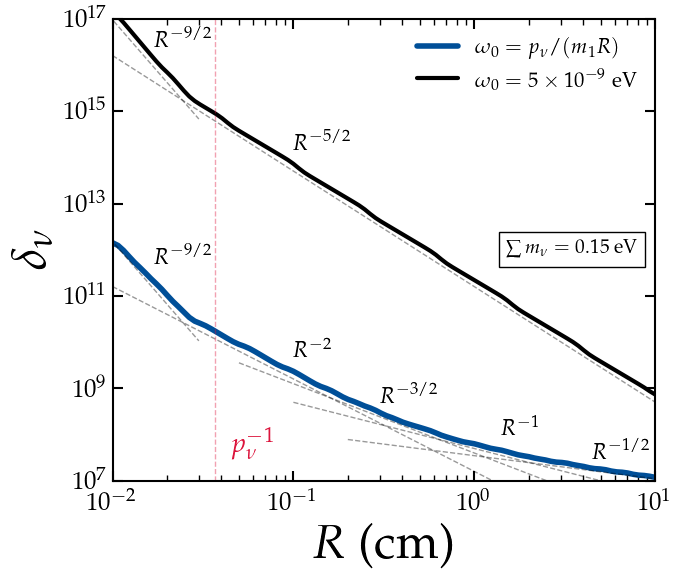

In [349]:
ss = 1

norm = 1000**(3/2)*10

r1 = np.geomspace(0.001, 0.03, 30)
r2 = np.geomspace(0.05, 10, 30)
r3 = np.geomspace(0.1, 10, 30)
r4 = np.geomspace(0.2, 10, 30)

fig, ax = plt.subplots(figsize=(7,6))

plt.loglog(rl, sn.gaussian_filter(dell_r, sigma=ss)/norm, label=r'$\omega_0=p_{\nu}/(m_1 R)$', c='#004f98', lw=4)
plt.loglog(rl, sn.gaussian_filter(dell_r2, sigma=ss)/norm, label=r'$\omega_0=5\times 10^{-9}$ eV', c='k',)

alp = 0.4
plt.loglog(r1, 9.5e7*r1**(-9/2),  ls='--', c='k', lw=1, alpha=alp)
plt.loglog(rl, 1.6e11*rl**(-5/2), ls='--', c='k', lw=1, alpha=alp)
plt.loglog(r1, 1.5e3*r1**(-9/2),  ls='--', c='k', lw=1, alpha=alp)
plt.loglog(rl, 1.6e7*rl**(-2),    ls='--', c='k', lw=1, alpha=alp)
plt.loglog(r2, 4e7*r2**(-3/2),    ls='--', c='k', lw=1, alpha=alp)
plt.loglog(r3, 5e7*r3**(-1),      ls='--', c='k', lw=1, alpha=alp)
plt.loglog(r4, 3.5e7*r4**(-1/2),  ls='--', c='k', lw=1, alpha=alp)

# plt.axvline(2*np.pi/27, alpha=0.4, lw=1)
plt.axvline(1/27, alpha=0.4, lw=1, c='crimson', ls='--')
plt.text(0.045, 4e7, r'$p^{-1}_\nu$', c='crimson')

ttfs = 16

plt.text(0.017, 2.5e16, r'$R^{-9/2}$', fontsize=ttfs)
plt.text(0.017, 5e11, r'$R^{-9/2}$', fontsize=ttfs)
plt.text(0.1,  1.5e14, r'$R^{-5/2}$', fontsize=ttfs)
plt.text(0.1,  5e9, r'$R^{-2}$', fontsize=ttfs)
plt.text(0.3,  5e8, r'$R^{-3/2}$', fontsize=ttfs)
plt.text(1.4,  1e8, r'$R^{-1}$', fontsize=ttfs)
plt.text(4.5,  3e7, r'$R^{-1/2}$', fontsize=ttfs)

plt.xlim(1e-2, 10)
plt.ylim(1e7, 1e17)

text_box = AnchoredText(
    #r"$m_1=0.05$ eV", 
    r"$\sum m_\nu=0.15$ eV", 
    loc='center right',            
    frameon=True,                
    prop=dict(size=14)
)
ax.add_artist(text_box)

plt.xlabel(r'$R$ (cm)')
plt.ylabel(r'$\delta_{\nu}$')
plt.legend()
plt.show()
#fig.savefig(main_dir+'plots/deltaR_scaling.pdf', bbox_inches='tight')

## ${\cal F}_{\rm SQUID}$ dependence

In [44]:
sql = np.geomspace(0.001, 200, 100)
dell_sq = []
dell_sq2 = []
for sq in tqdm.tqdm(sql):
    de, c2, _  = find_delta(10, 0.16,  T2=0.1, Nshots=10, seed=23, d_init=1e11, d_fin=1e22, ndelta=200, squid_noise_ratio=sq)
    de2, c2, _  = find_delta(10, 0.16, T2=0.1, Nshots=10, seed=42, d_init=1e11, d_fin=1e22, ndelta=200, squid_noise_ratio=sq)
    dell_sq.append(de)
    dell_sq2.append(de2)

dell_sq = np.array(dell_sq)
dell_sq2 = np.array(dell_sq2)

100%|██████████████████████████████████████████████████████████| 100/100 [01:57<00:00,  1.18s/it]


In [7]:
# dell_sq3 = dell_sq
# dell_sq4 = dell_sq2

In [45]:
me_sq = np.mean(np.array([dell_sq/dell_sq[0], dell_sq2/dell_sq2[0], dell_sq3/dell_sq3[0], dell_sq4/dell_sq4[0]]), axis=0)

In [10]:
np.savetxt(main_dir+'data/fsquid_dep.txt', np.column_stack([sql, me_sq]))

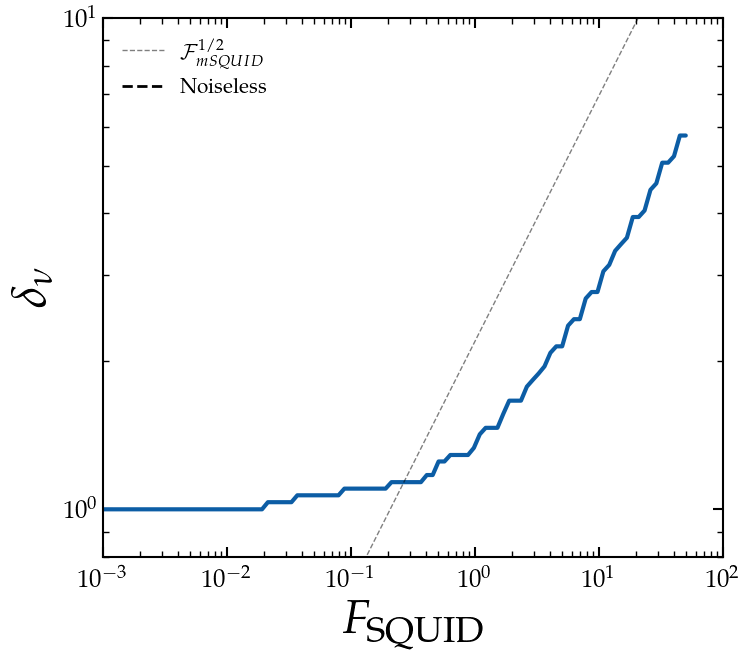

In [16]:
# plt.loglog(sql, dell_sq/dell_sq[0], label='seed: 42')
# plt.loglog(sql, dell_sq2/dell_sq2[0], label='seed: 23')
plt.loglog(sql, me_sq)
plt.loglog(sql, 2.2*sql**(1/2), ls='--', lw=1, alpha=0.5,c='k', label='${\cal F}_{\rm SQUID}^{1/2}$')

de0, _, _ = find_delta(10, 0.16,  T2=1, Nshots=100, seed=42, d_init=1e11, d_fin=1e22, ndelta=200, squid_noise_ratio=0)

plt.hlines(de0, xmin=1e-3, xmax=50, ls='--', color='k', label='Noiseless', lw=2)
plt.xlim(1e-3,100)
plt.ylim(0.8,10)
plt.xlabel(r'$F_{\rm SQUID}$')
plt.ylabel(r'$\delta_{\nu}$')
plt.legend()
plt.show()

## $T_2$ dependence

In [17]:
t2l = np.geomspace(0.1, 100, 100)
dell_t1 = []
dell_t2 = []
dell_t3 = []
dell_t4 = []
for tt in tqdm.tqdm(t2l):
    de, _,_  = find_delta(10, 0.16, T2=tt, Nshots=100, seed=24, d_init=1e8, d_fin=1e14, ndelta=200)
    dell_t1.append(de)
    de, _,_  = find_delta(10, 0.16, T2=tt, Nshots=100, seed=11, d_init=1e8, d_fin=1e14, ndelta=200)
    dell_t2.append(de)
    de, _,_  = find_delta(10, 0.16, T2=tt, Nshots=100, seed=24, d_init=1e8, d_fin=1e14, ndelta=200)
    dell_t3.append(de)
    de, _,_  = find_delta(10, 0.16, T2=tt, Nshots=100, seed=11, d_init=1e8, d_fin=1e14, ndelta=200)
    dell_t4.append(de)

dell_t1 = np.array(dell_t1)
dell_t2 = np.array(dell_t2)
dell_t3 = np.array(dell_t3)
dell_t4 = np.array(dell_t4)
me_t = np.mean(np.array([dell_t1/dell_t1[0], dell_t2/dell_t2[0], dell_t3/dell_t3[0], dell_t4/dell_t4[0]]), axis=0)


100%|██████████████████████████████████████████████████████████| 100/100 [13:05<00:00,  7.86s/it]


In [22]:
np.savetxt(main_dir+'data/T2_dep.txt', np.column_stack([t2l, me_t]))

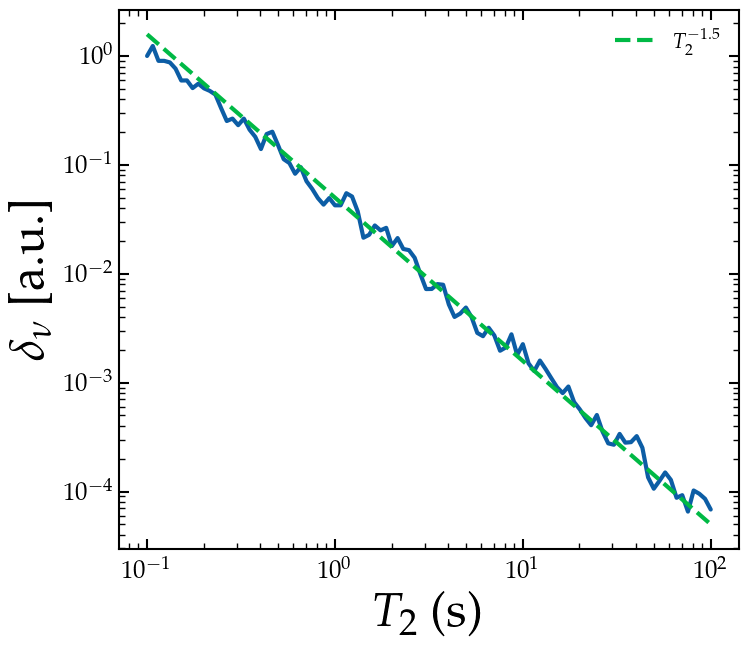

In [19]:
plt.loglog(t2l, me_t)
plt.loglog(t2l, 0.05*t2l**(-1.5), ls='--', label=r'$T_2^{-1.5}$')

plt.xlabel(r'$T_2$ (s)')
plt.ylabel(r'$\delta_{\nu}$ [a.u.]')
plt.legend()
plt.show()

## $N_{\rm shots}$ dependence

In [21]:
de, _, _ = find_delta(10, 0.16, T2=0.01, Nshots=1000, seed=24, d_init=1e12, d_fin=1e17, ndelta=200)
print("%.3e"%de)

3.449e+14


In [32]:
nsl = np.geomspace(5, 1000, 100)
nsl_int = [int(ns) for ns in nsl]

d, d2, d3 = [], [], []

for see in [11, 25, 43, 51]:    
    dell_seed, dell2_seed, dell3_seed = [], [], []

    for ns in tqdm.tqdm(nsl_int):
        de, _, _ = find_delta(10, 0.16, T2=0.01, Nshots=ns, seed=see, d_init=1e12, d_fin=1e19, ndelta=200)
        dell_seed.append(de)

        de, _, _ = find_delta(10, 0.16, T2=0.01, Nshots=ns, seed=see, d_init=1e12, d_fin=1e19, ndelta=200, squid_noise_ratio=1)
        dell2_seed.append(de)

        de, _, _ = find_delta(10, 0.16, T2=0.01, Nshots=ns, seed=see, d_init=1e12, d_fin=1e19, ndelta=200, squid_noise_ratio=10)
        dell3_seed.append(de)

    d.append(dell_seed)
    d2.append(dell2_seed)
    d3.append(dell3_seed)

d = np.array(d)     # shape: (n_seeds, len(nsl))
d2 = np.array(d2)
d3 = np.array(d3)

me_ns1 = np.mean(d, axis=0)
me_ns2 = np.mean(d2, axis=0)
me_ns3 = np.mean(d3, axis=0)

100%|██████████████████████████████████████████████████████████| 100/100 [02:53<00:00,  1.73s/it]


In [ ]:
np.savetxt(main_dir+'data/Ns1_dep.txt', np.column_stack([nsl, me_ns1]))
np.savetxt(main_dir+'data/Ns2_dep.txt', np.column_stack([nsl, me_ns2]))
np.savetxt(main_dir+'data/Ns3_dep.txt', np.column_stack([nsl, me_ns3]))

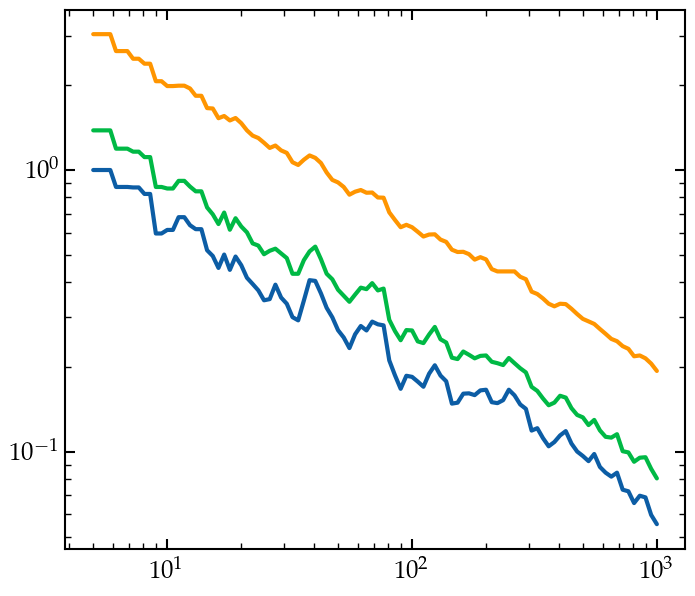

In [34]:
plt.loglog(nsl,me_ns1/me_ns1[0])
plt.loglog(nsl, me_ns2/me_ns1[0])
plt.loglog(nsl, me_ns3/me_ns1[0])
#plt.loglog(nsl, 2*nsl**(-0.5), ls='--')

In [430]:
# sql, me_sq = np.loadtxt(main_dir+'/data/fsquid_dep.txt', unpack=True)
# t2l, me_t  = np.loadtxt(main_dir+'/data/T2_dep.txt', unpack=True)
# rl,  me_r  = np.loadtxt(main_dir+'/data/R_dep.txt', unpack=True)

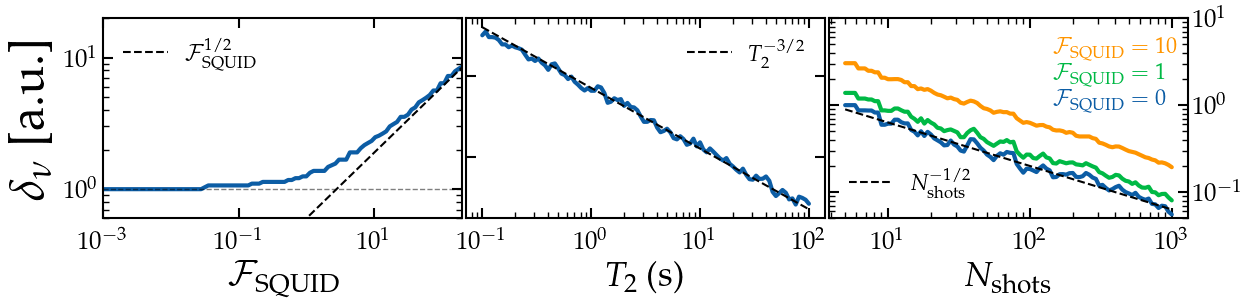

In [82]:
fig, ax = plt.subplots(1, 3, figsize=(14, 2.6))
fig.subplots_adjust(wspace=0.01, hspace=0.34)
fs = 16


#-----------------------------------------------------------------------------------------------------------
ax[0].loglog(sql, me_sq)
ax[0].loglog(sql, 0.6*sql**(1/2), ls='--', lw=1.5, alpha=1,c='k', label=r'${\cal F}_{\rm SQUID}^{1/2}$')
ax[0].loglog(sql, sql/sql, c='k', ls='--', lw=1, alpha=0.5)

ax[0].set_xlim(1e-3, 200)
ax[0].set_ylim(0.6, 20)
ax[0].legend(fontsize=fs, frameon=False)
ax[0].set_xlabel(r'${\cal F}_{\rm SQUID}$', fontsize=25)
ax[0].set_ylabel(r'$\delta_\nu$ [a.u.]')
#ax[0].tick_params(labelleft=False, labelright=True)


# #-----------------------------------------------------------------------------------------------------------
ax[1].loglog(t2l, me_t)
ax[1].loglog(t2l, 0.05*t2l**(-1.5), ls='--', label=r'$T_2^{-3/2}$', c='k',lw=1.5)
ax[1].legend(fontsize=fs, frameon=False)
ax[1].set_xlabel(r'$T_2$ (s)', fontsize=25)
ax[1].tick_params(labelleft=False, labelright=False)
#ax[1].set_ylabel(r'$\delta_\nu$ [a.u.]')

# #-----------------------------------------------------------------------------------------------------------

ax[2].loglog(nsl,me_ns1/me_ns1[0])#, label=r'${\cal F}_{\rm SQUID}=10$')
ax[2].loglog(nsl, me_ns2/me_ns1[0])#, label=r'${\cal F}_{\rm SQUID}=10$')
ax[2].loglog(nsl, me_ns3/me_ns1[0])#, label=r'${\cal F}_{\rm SQUID}=10$')
ax[2].loglog(nsl, 2*nsl**(-0.5), ls='--', c='k', lw=1.5, alpha=1, label=r'$N_{\rm shots}^{-1/2}$')
ax[2].text(145, 4,r'${\cal F}_{\rm SQUID}=10$',c='C2', fontsize=16)
ax[2].text(145, 2,r'${\cal F}_{\rm SQUID}=1$',c='C1', fontsize=16)
ax[2].text(145, 1,r'${\cal F}_{\rm SQUID}=0$',c='C0', fontsize=16)
ax[2].set_xlabel(r'$N_{\rm shots}$', fontsize=25)
ax[2].set_ylim(0.05, 10)
ax[2].legend(fontsize=fs, loc=3)
ax[2].tick_params(labelleft=False, labelright=True)

# plt.tight_layout()
plt.show()
#fig.savefig(main_dir+'plots/delta_scaling.pdf', bbox_inches='tight')

## Mass plot

In [25]:
mnl = np.linspace(0.005, 1, 50)
dell_m = []
dell_m_0 = []

for m in tqdm.tqdm(mnl):
    de, c2, _ = on.find_delta(1, m, T2=10, Nshots=10, seed=42, d_init=1e7, d_fin=1e16, ndelta=100, squid_noise_ratio=50.0)
    dell_m.append(de)
    de, c2, _ = on.find_delta(10, m, T2=10, Nshots=10, seed=42, d_init=1e7, d_fin=1e16, ndelta=100, squid_noise_ratio=0.0)
    dell_m_0.append(de)

dell_m = np.array(dell_m)
dell_m_0 = np.array(dell_m_0)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:29<00:00,  2.98s/it]


In [29]:
dm = sn.gaussian_filter(dell_m, sigma=1.5)
dm_0 = sn.gaussian_filter(dell_m_0, sigma=1.5)

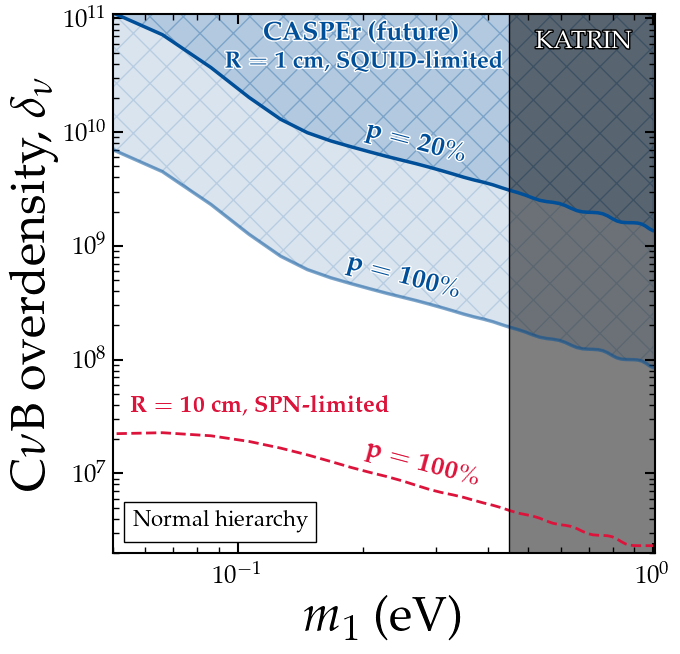

In [94]:
fig, ax = plt.subplots(figsize=(7,7))


c1 = '#004f98'
c2 = 'navy'

al = 0.05

f1 = 100**(3/2)*10*(1*0.25)**2     # T2=1000, Nshots=1000, p=0.1, FSQUID=50
f2 = 100**(3/2)*10                # T2=1000, Nshots=1000, p=1,   FSQUID=50 
f4 = 100**(3/2)*10                # T2=1000, Nshots=1000, p=1,   FSQUID=0  

plt.loglog(mnl, dm/f1, c=c1, lw=2.5)
plt.fill_between(mnl, dm/f1, 1e16*np.ones(len(mnl)), alpha=0.3, color=c1, hatch='X')

plt.loglog(mnl, dm/f2, c=c1, lw=2.5, alpha=0.5)
plt.fill_between(mnl, dm/f2, dm/f1, alpha=0.15, color=c1, hatch='X')

tc = plt.text(0.115,6.5e10,r'{\bf CASPEr (future)}', fontsize=19, c=c1)
tc.set_path_effects([pe.Stroke(linewidth=2, foreground='w'),
                     pe.Normal()])

tc2 = plt.text(0.093,3.7e10,r'${\bf R=1}$ {\bf cm}, {\bf SQUID-limited}', fontsize=17, c=c1)
tc2.set_path_effects([pe.Stroke(linewidth=2, foreground='w'),
                     pe.Normal()])

tp1 = plt.text(0.2,5.5e9,r'${\bf p=20\%}$', fontsize=19,c=c1, alpha=1, rotation=-15)
tp2 = plt.text(0.18,3.5e8,r'${\bf p=100\%}$', fontsize=19,c=c1, alpha=1, rotation=-15)
tp1.set_path_effects([pe.Stroke(linewidth=2, foreground='w'),
                     pe.Normal()])
tp2.set_path_effects([pe.Stroke(linewidth=2, foreground='w'),
                     pe.Normal()])

plt.loglog(mnl, dm_0/f4, c='crimson', lw=2, ls='--')
plt.text(0.055,3.5e7,r'${\bf R=10}$ {\bf cm}, {\bf SPN-limited}', fontsize=17,c='crimson', rotation=0)
tp2 = plt.text(0.2,8e6,r'${\bf p=100\%}$', fontsize=19,c='crimson', alpha=1, rotation=-15)

mm = np.geomspace(1e-3, 2,100)
mm2 = np.geomspace(1e-3, 0.45,100)
#plt.fill_between(mm, 1e11,  1e15, alpha=0.5, color='k')

yy = np.geomspace(1e6,2e11,100)
plt.axvline(0.45, c='k', lw=1)
plt.fill_betweenx(yy, 0.45, 2, color='k', alpha=0.5, lw=0.001)
tk = plt.text(5.2e-1, 5.5e10, 'KATRIN', fontsize=18, alpha=1, c='w', rotation=0)
#tk = plt.text(6e-1, 1e10, 'KATRIN', fontsize=19, alpha=1, c='w', rotation=-90)
tk.set_path_effects([pe.Stroke(linewidth=2, foreground='black'),
                     pe.Normal()])

text_box = AnchoredText(
    fr"Normal hierarchy", 
    loc='lower left',            
    frameon=True,                
    prop=dict(size=16)
)
ax.add_artist(text_box)

plt.xlabel(r'$m_1$ (eV)')
plt.ylabel(r'C$\nu$B overdensity, $\delta_{\nu}$')
plt.xlim(5e-2, 1.01)
plt.ylim(2e6, 1.1e11)
plt.show()
fig.savefig(main_dir+'plots/deltanu_m1.pdf', bbox_inches='tight')

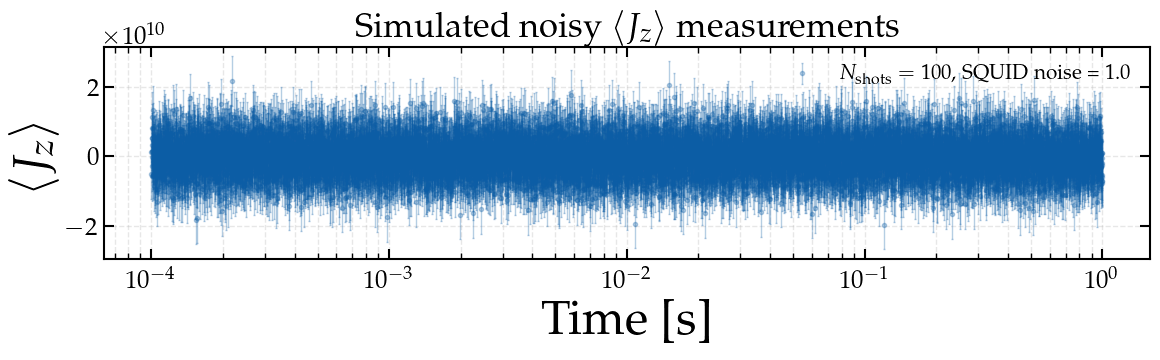

In [78]:
N = int(1e22)
Nshots = 100
sampf = 1e4
tf = 1
ti = 1 / sampf
squid_noise_ratio = 1.0  # Adjust as needed
sk = 1  # skip factor for plotting

# Time grid
n_times = int((tf - ti) * sampf)
t_exp = np.geomspace(ti, tf, n_times)

# Simulate noisy measurements of J_z (mean zero)
np.random.seed(42)
jz_true_mean = 0.0
jz_true_std = np.sqrt(N / 4)
Jz_samples = np.random.normal(jz_true_mean, jz_true_std, size=(n_times, Nshots))
Jz_mean_exp = np.mean(Jz_samples, axis=1)

# Total error: quantum + SQUID noise
sigma_jz = np.sqrt(N / 4 / Nshots * (1 + squid_noise_ratio)) * np.ones(n_times)

# Plot
plt.figure(figsize=(12, 4))
plt.errorbar(t_exp[::sk], Jz_mean_exp[::sk], yerr=sigma_jz[::sk],
             fmt='o', label=fr'$N_{{\rm shots}}={Nshots}$, SQUID noise = {squid_noise_ratio}',
             alpha=0.3, markersize=3, lw=1, capsize=1)

plt.xscale('log')
plt.xlabel("Time [s]")
plt.ylabel(r"$\langle J_z \rangle$")
plt.title("Simulated noisy $\langle J_z \\rangle$ measurements")
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.tight_layout()
plt.show()